## Library

In [344]:
import math
import random
import numpy as np
from copy import copy
from scipy import stats
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

exec(open('library.py').read())
print('Loaded 2')

STATES = ['boring', 'xrisk_unaligned_tai', 'aligned_tai', 'xrisk_unknown_unknown', 'xrisk_tai_misuse',
          'xrisk_nanotech', 'xrisk_nukes_war', 'xrisk_bio_accident', 'xrisk_bio_war', 'xrisk_bio_nonstate']

def print_states(collector):
    c = Counter([r[0]['category'] for r in collector])
    c = dict([(k, round(v / RUNS * 100, 1)) for k, v in c.items()])
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c

print('Loaded 3')

Loaded
Loaded 2
Loaded 3


## Variables (customize these)

In [345]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 1000                                       # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
CREDIBLE_INTERVAL = 0.9                           # CIs are 90% CIs


# This is a PDF for when TAI will be available to be developed. Look to `When TAI?` notebook to generate this.
tai_pdf = [0.003, 0.004, 0.003, 0.004, 0.007, 0.008, 0.015, 0.014, 0.016,
       0.013, 0.017, 0.02 , 0.018, 0.022, 0.021, 0.032, 0.021, 0.017,
       0.025, 0.021, 0.017, 0.025, 0.022, 0.028, 0.012, 0.028, 0.013,
       0.021, 0.011, 0.017, 0.029, 0.025, 0.012, 0.016, 0.009, 0.014,
       0.011, 0.012, 0.009, 0.011, 0.013, 0.01 , 0.009, 0.012, 0.008,
       0.01 , 0.012, 0.006, 0.004, 0.002, 0.004, 0.006, 0.005, 0.007,
       0.005, 0.007, 0.004, 0.004, 0.005, 0.002, 0.002, 0.001, 0.009,
       0.009, 0.002, 0.004, 0.003, 0.002, 0.002, 0.   , 0.004, 0.003,
       0.003, 0.004, 0.003, 0.005, 0.004, 0.   , 0.003, 0.004, 0.   ,
       0.001, 0.001, 0.002, 0.001, 0.   , 0.001, 0.002, 0.002, 0.003,
       0.002, 0.002, 0.001, 0.   , 0.   , 0.001, 0.005, 0.001, 0.001,
       0.002, 0.   , 0.001, 0.   , 0.002, 0.001, 0.   , 0.001, 0.003,
       0.001, 0.   , 0.001, 0.002, 0.   , 0.001, 0.   , 0.   , 0.001,
       0.002, 0.   , 0.   , 0.001, 0.002, 0.   , 0.002, 0.   , 0.001,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.001, 0.   , 0.   ,
       0.002, 0.001, 0.   , 0.   , 0.001, 0.   , 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.001, 0.001, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.002,
       0.001, 0.   , 0.   , 0.   , 0.001, 0.001, 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.001, 0, 0]
tai_pdf = np.array(tai_pdf)


# Make the chance TAI alignment is solved be a function of year
# This version starts at 30% and rises to 75% over time
# 30% can be best interpreted here as the likelihood that AI is "safe by default"
def p_alignment_solved(war, year, first_attempt=True):
    if first_attempt:
        p = min(0.3 + 0.3*(year/100), 0.75)
    else:
        p = min(0.4 + 0.35*(year/100), 0.85)
    if war:
        p = p * (2/3)
    return p

# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making an unaligned agentic TAI, will it produce an xrisk?
p_unaligned_tai_is_xrisk = 0.9 * 0.4 * 0.98

# Conditional on having TAI available, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.1

# What is the chance in a given year there will be a great power war?
def p_great_power_war(year):
    if year < 2025:
        return 0.006
    elif year < 2030:
        return 0.006 + 0.3*0.01*0.2
    elif year < 2040:
        return 0.006 + 0.002 + 0.05*0.01*0.2
    else:
        return (0.006 + 0.05*0.05*0.2) * (0.99 ** year)

# Conditional on a great power war starting, how long will it last?
war_length = lognorm(2, 50) # 90% CI

# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.06 if war else 0.02
    p = p * (0.995 ** year)
    return p
# TODO: Graph

# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.12 if war else 0.05

# Conditional on a nuclear exchange, what is the chance it escalates into a xrisk?
def p_xrisk_from_nuclear_exchange(war):
    p = 0.6 if war else 0.3
    p = p * 0.8 * 0.1 * 0.2
    return p
    # TODO: maybe also change arsenal size over time?

# What is the chance of an accidental biorisk (e.g., lab leak)?
def p_accidental_bio(war):
    return 0.01 if war else 0.001
    
# Conditional on a accidental biorisk, what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio(year):
    p = 0.2 * 0.2 * 0.2
    p = p * (0.99 ** year)
    return p
# TODO: Graph
    
# Conditional on a great power war, what is the chance it goes nuclear in any given year?
p_nuclear_war_given_war = 0.05

# Conditional on a great power war, what is the chance it results in a bioweapon?
p_biowar_given_war = 0.02

# What is the chance of a non-state actor creating a biorisk?
p_nonstate_bio = 0.001

# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_intentional_bio(year):
    p = 0.2 * 0.2
    p = p * (0.995 ** year)
    return p
# TODO: Graph

# Wha is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1
# TODO: Graph

# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1

# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return 0.0001 / (0.99 ** year) # TODO: This goes over 1
# TODO: Graph
    

# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')

Loaded


## TAI Timelines

Text(0, 0.5, 'chance of TAI IN year')

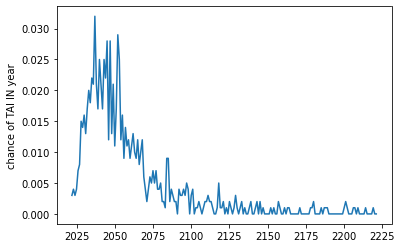

In [346]:
plt.plot(years, tai_pdf)
plt.ylabel('chance of TAI IN year')


Text(0, 0.5, 'chance of TAI BY year')

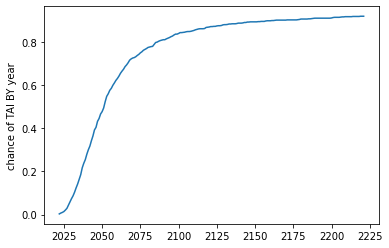

In [347]:
tai_cdf = np.cumsum(tai_pdf)
plt.plot(years, tai_cdf)
plt.ylabel('chance of TAI BY year')


## Chance of Solving Alignment by Year (Conditional on TAI in that year, no war, first attempt)

Text(0, 0.5, 'chance of solving alignment if TAI in year')

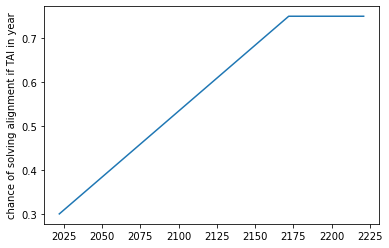

In [348]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
plt.plot(years, alignment_p)
plt.ylabel('chance of solving alignment if TAI in year')


In [349]:
for y in years:
    print('Year: {} - chance of solving TAI alignment {}%'.format(y,
                                                                  np.round(alignment_p[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment 30.0%
Year: 2023 - chance of solving TAI alignment 30.0%
Year: 2024 - chance of solving TAI alignment 31.0%
Year: 2025 - chance of solving TAI alignment 31.0%
Year: 2026 - chance of solving TAI alignment 31.0%
Year: 2027 - chance of solving TAI alignment 32.0%
Year: 2028 - chance of solving TAI alignment 32.0%
Year: 2029 - chance of solving TAI alignment 32.0%
Year: 2030 - chance of solving TAI alignment 32.0%
Year: 2031 - chance of solving TAI alignment 33.0%
Year: 2032 - chance of solving TAI alignment 33.0%
Year: 2033 - chance of solving TAI alignment 33.0%
Year: 2034 - chance of solving TAI alignment 34.0%
Year: 2035 - chance of solving TAI alignment 34.0%
Year: 2036 - chance of solving TAI alignment 34.0%
Year: 2037 - chance of solving TAI alignment 34.0%
Year: 2038 - chance of solving TAI alignment 35.0%
Year: 2039 - chance of solving TAI alignment 35.0%
Year: 2040 - chance of solving TAI alignment 35.0%
Year: 2041 - chance of solving 

## Great Power War

Text(0, 0.5, 'chance of great power war IN year')

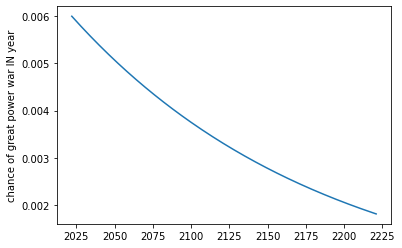

In [350]:
war_pdf = np.array([p_great_power_war(y - CURRENT_YEAR) for y in years])
war_pdf = [war_pdf[0] if x == 0 else war_pdf[x] * np.prod(1 - war_pdf[:x]) for x in range(MAX_YEAR - CURRENT_YEAR)]
plt.plot(years, war_pdf)
plt.ylabel('chance of great power war IN year')


Text(0, 0.5, 'chance of great power war BY year')

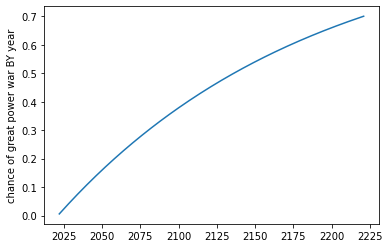

In [351]:
war_cdf = np.cumsum(war_pdf)
plt.plot(years, war_cdf)
plt.ylabel('chance of great power war BY year')


In [352]:
for y in years:
    print('Year: {} - chance of war IN year {}%, BY year {}%'.format(y,
                                                                     np.round(war_pdf[y - CURRENT_YEAR] * 100, 1),
                                                                     np.round(war_cdf[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - chance of war IN year 0.6%, BY year 0.6%
Year: 2023 - chance of war IN year 0.6%, BY year 1.2%
Year: 2024 - chance of war IN year 0.6%, BY year 1.8%
Year: 2025 - chance of war IN year 0.6%, BY year 2.4%
Year: 2026 - chance of war IN year 0.6%, BY year 3.0%
Year: 2027 - chance of war IN year 0.6%, BY year 3.5%
Year: 2028 - chance of war IN year 0.6%, BY year 4.1%
Year: 2029 - chance of war IN year 0.6%, BY year 4.7%
Year: 2030 - chance of war IN year 0.6%, BY year 5.3%
Year: 2031 - chance of war IN year 0.6%, BY year 5.8%
Year: 2032 - chance of war IN year 0.6%, BY year 6.4%
Year: 2033 - chance of war IN year 0.6%, BY year 7.0%
Year: 2034 - chance of war IN year 0.6%, BY year 7.5%
Year: 2035 - chance of war IN year 0.6%, BY year 8.1%
Year: 2036 - chance of war IN year 0.6%, BY year 8.6%
Year: 2037 - chance of war IN year 0.5%, BY year 9.2%
Year: 2038 - chance of war IN year 0.5%, BY year 9.7%
Year: 2039 - chance of war IN year 0.5%, BY year 10.3%
Year: 2040 - chance of war 

In [353]:
war_length_p = get_percentiles([sample(war_length, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
war_length_p

{95: 2.07327523183118,
 90: 3.1804161890558964,
 80: 4.548159483616467,
 70: 5.964695830796765,
 60: 7.819231597048575,
 50: 10.314282354157994,
 40: 12.87040166233115,
 30: 16.386962983904965,
 20: 21.75221887745671,
 10: 34.806132755554,
 5: 50.89510902912021}

## Run Model

In [354]:
def p_tai_occurs_in(year):
    if year < 0:
        raise ValueError
    elif year == 0:
        return tai_pdf[0]
    else:
        return tai_pdf[year] / (1 - sum(tai_pdf[y] for y in range(year)))
    

collectors = {}
collect_years = [2022, 2025, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2150, 2200]
for y in collect_years:
    collectors[y] = []

results = []
print('Loaded')
print('-')

for r in range(RUNS):
    print('## RUN {}/{} ##'.format(r + 1, RUNS))
    terminate = False; terminate_y = None
    state = {'category': 'boring', 'tai': False, 'tai_type': None, 'nano': False, 'war': False}
    
    for y in years:
        if not terminate:
            print('Year {}'.format(y))
            
            ## TAI Scenarios
            if not terminate and (event_occurs(p_tai_occurs_in(y - CURRENT_YEAR)) or state['tai']):
                if (event_occurs(p_make_agent_tai) or state['tai_type'] == 'agent') and state['tai_type'] != 'tool':
                    # TODO: Do we want to re-roll the possibility of making agentic TAI in future years?
                    if event_occurs(p_alignment_solved(state['war'], y - CURRENT_YEAR, first_attempt=state['tai'])):
                        print('...Acheived aligned TAI, happy future! :D')
                        state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                        # TODO: Does aligned TAI make all other xrisks impossible? We currently assume it does
                            # TODO: Maybe introduce takeoff delay before other xrisks become impossible?
                    elif event_occurs(p_unaligned_tai_is_xrisk):
                        print('...XRISK from unaligned TAI :(')
                        state['category'] = 'xrisk_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                    elif event_occurs(p_tai_intentional_misuse(state['war'])):
                        print('...XRISK from intentional misuse of TAI :(')
                        state['category'] = 'xrisk_tai_misuse'; state['tai'] = True; state['tai_type'] = 'agent'
                        terminate = True; terminate_y = y
                    else:
                        state['tai'] = True; state['tai_type'] = 'agent'
                        # TODO: These scenarios require more analysis
                else:
                    state['tai'] = True; state['tai_type'] = 'tool'
                    # TODO: Does tool AI help mitigate xrisk?
            # TODO: TAI or nearness to TAI creates great power war
            
                                      
            ## Great power war scenarios
            if not terminate and (event_occurs(p_great_power_war(y - CURRENT_YEAR)) and not state['war']):
                print('WAR!!!')
                state['war'] = True
                war_end_year = sample(war_length, credibility=CREDIBLE_INTERVAL) + y
            
            if state['war'] and y >= war_end_year:
                print('War ends :)')
                state['war'] = False

            
            ## Nuclear scenarios
            if not terminate and event_occurs(p_nuclear_accident(state['war'], y)):
                if event_occurs(p_nuclear_accident_becomes_exchange(state['war'])):
                    if event_occurs(p_xrisk_from_nuclear_exchange(state['war'])):
                        print('...XRISK from nukes (accidental exchange) :(')
                        state['category'] = 'xrisk_nukes_accident'
                        terminate = True; terminate_y = y

            if not terminate and state['war'] and event_occurs(p_nuclear_war_given_war):
                if event_occurs(p_xrisk_from_nuclear_exchange(state['war'])):
                    print('...XRISK from nukes (war) :(')
                    state['category'] = 'xrisk_nukes_war'
                    terminate = True; terminate_y = y
            
                                      
            ## Bio scenarios
            if not terminate and event_occurs(p_accidental_bio(state['war'])):
                if event_occurs(p_xrisk_from_accidental_bio(y - CURRENT_YEAR)):
                    print('...XRISK from pathogen (accidental) :(')
                    state['category'] = 'xrisk_bio_accident'
                    terminate = True; terminate_y = y
                    
            if not terminate and event_occurs(p_nonstate_bio):
                if event_occurs(p_xrisk_from_intentional_bio(y - CURRENT_YEAR)):
                    print('...XRISK from pathogen (nonstate actor) :(')
                    state['category'] = 'xrisk_bio_nonstate'
                    terminate = True; terminate_y = y
                    
            if not terminate and state['war'] and event_occurs(p_biowar_given_war):
                if event_occurs(p_xrisk_from_intentional_bio(y - CURRENT_YEAR)):
                    print('...XRISK from pathogen (war) :(')
                    state['category'] = 'xrisk_bio_war'
                    terminate = True; terminate_y = y
            
            
            ## Nanotech scenarios
            if not terminate and event_occurs(p_nanotech_possible(y - CURRENT_YEAR)) and not state['nano']:
                state['nano'] = True
                if event_occurs(p_nanotech_is_xrisk):
                    print('...XRISK from nanotech :(')
                    state['category'] = 'xrisk_nanotech'
                    terminate = True; terminate_y = y
            
            
            ## "Unknown unknown" scenarios
            if not terminate and event_occurs(p_unknown_unknown_xrisk(y - CURRENT_YEAR)):
                print('...XRISK from unknown unknown')
                state['category'] = 'xrisk_unknown_unknown'
                terminate = True; terminate_y = y
    
    
        ## Run collectors
        for y_c in collect_years:
            if y == y_c:
                collectors[y_c].append([copy(state), terminate_y])
                
    ## Boring future if MAX_YEAR is reached with no termination
    if not terminate:
        print('...Boring future')
        terminate_y = y

    print('-')
    print('-')

Loaded
-
## RUN 1/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
...XRISK from unaligned TAI :(
-
-
## RUN 2/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
...Acheived aligned TAI, happy future! :D
-
-
## RUN 3/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055

Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 29/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
...Acheived aligned TAI, happy future! :D
-
-
## RUN 30/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 20

Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
...Acheived aligned TAI, happy future! :D
-
-
## RUN 58/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
...XRISK from unaligned TAI :(
-
-
## RUN 59/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
WAR!!!
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
War ends :)
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year

Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
WAR!!!
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
War ends :)
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Y

Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
...Acheived aligned TAI, happy future! :D
-
-
## RUN 103/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
...XRISK from intentional misuse of TAI :(
-
-
## RUN 104/1000 ##
Year 2022
Year 2023
Year 2024
WAR!!!
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
War ends :)
Year 2032
Year 2033
Year 2034
Year 2035
WAR!!!
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Yea

Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
...XRISK from unaligned TAI :(
-
-
## RUN 126/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
...XRISK from unaligned TAI :(
-
-
## RUN 127/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
...XRISK from unaligned TAI :(
-
-
## RUN 128/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 202

Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194


Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 168/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
...XRISK from unaligned TAI :(
-
-
## RUN 169/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2

Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
WAR!!!
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Yea

## RUN 213/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
...Acheived aligned TAI, happy future! :D
-
-
## RUN 214/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2

Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
WAR!!!
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
War ends :)
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Y

Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 258/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
...Acheived aligned TAI, happy future! :D
-
-
## RUN 259/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 

Year 2025
WAR!!!
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
War ends :)
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
...Acheived aligned TAI, happy future! :D
-
-
## RUN 274/1000 ##
Year 2022
Year 2023
Year 2

Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148


Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 329/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036


Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
WAR!!!
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
...Acheived aligned TAI, happy future! :D
War ends :)
-
-
## RUN 345/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2

Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
WAR!!!
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 366/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Yea

Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
...Acheived aligned TAI, happy future! :

Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201


Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 405/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
...XRISK from unaligned TAI :(
-
-
## RUN 406/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
WAR!!!
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
War ends :)
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
WAR!!!
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060


Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
WAR!!!
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
War ends :)
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 424/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
...Acheived aligned TAI, happy future! :D
-
-
## RUN 425/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2

-
-
## RUN 451/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
WAR!!!
Year 2098
Year 2099
Year 2100
Year 2101
War ends :)
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 211

Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 474/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072


WAR!!!
Year 2037
Year 2038
War ends :)
Year 2039
Year 2040
Year 2041
...XRISK from unaligned TAI :(
-
-
## RUN 493/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
...XRISK from unaligned TAI :(
-
-
## RUN 494/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
WAR!!!
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2

Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
WAR!!!
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
War ends :)
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Y

Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
...Acheived aligned TAI, happy future! :D
-
-
## RUN 540/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 

Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
War ends :)
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 214

Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
WAR!!!
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Yea

Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
War ends :)
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 596/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
WAR!!!
Year 2042
Year 2043
War ends :)
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
...XRISK from unaligned TAI :(
-
-
## RUN 597/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 

Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218


Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 642/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
...XRISK from unaligned TAI :(
-
-
## RUN 643/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
...XRISK from un

Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
...Acheived aligned TAI, happy future! :D
-
-
## RUN 671/1000 ##
Year 2022
Year 2023
...Acheived aligned TAI, happy future! :D
-
-
## RUN 672/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
WAR!!!
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
War ends :)
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
...Acheived aligned TAI, happy future! :D
-
-
## RUN 673/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2

Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 702/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
...Acheived aligned TAI, happy future! :D
-
-
## RUN 703/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 

Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189
Year 2190
Year 2191
Year 2192
Year 2193
Year 2194
Year 2195
Year 2196
Year 2197
Year 2198
Year 2199
Year 2200
Year 2201
Year 2202
Year 2203
Year 2204
Year 2205
Year 2206
Year 2207
Year 2208
Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 719/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
...XRISK from unaligned TAI :(
-
-
## RUN 720/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2

Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164


-
-
## RUN 767/1000 ##
Year 2022
Year 2023
Year 2024
WAR!!!
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
War ends :)
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
...Acheived aligned TAI, happy future! :D
-
-
## RUN 768/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Yea

Year 2209
Year 2210
Year 2211
Year 2212
Year 2213
Year 2214
Year 2215
Year 2216
Year 2217
Year 2218
Year 2219
Year 2220
Year 2221
...Boring future
-
-
## RUN 779/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
...Acheived aligned TAI, happy future! :D
-
-
## RUN 780/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
...Acheived aligned TAI, happy future! :D
-
-
## RUN 781/1000 ##
Year 2022
Year 2023
Year 2024


Year 2047
...XRISK from unaligned TAI :(
-
-
## RUN 804/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
...XRISK from unaligned TAI :(
-
-
## RUN 805/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
...Acheived aligned TAI, happy future! :D
-
-
## RUN 806/1000 ##
Year 2022
Year 2023
Year 20

## RUN 830/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Y

Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143


Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Year 2189


Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
...Acheived aligned TAI, happy future! :D
-
-
## RUN 884/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
...Acheived aligned TAI, happy future! :D
-
-
## RUN 885/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028


Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
...XRISK from unaligned TAI :(
-
-
## RUN 903/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
...Acheived aligned TAI, happy future! :D
-
-
## RUN 904/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Y

Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
War ends :)
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 216

Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
...XRISK from unaligned TAI :(
-
-
## RUN 956/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
Year 2042
Year 2043
Year 2044
Year 2045
Year 2046
Year 2047
Year 2048
Year 2049
Year 2050
Year 2051
Year 2052
Year 2053
Year 2054
Year 2055
Year 2056
Year 2057
Year 2058
Year 2059
Year 2060
Year 2061
Year 2062
Year 2063
Year 2064
Year 2065
Year 2066
Year 2067
Year 2068
Year 2069
Year 2070
Year 2071
Year 2072
Year 2073
Year 2074
Year 2075
Year 2076
Year 2077
Year 2078
Year 2079
Year 2080
Year 2081
Year 2082
Year 2083
Year 2084
Year 2085
Year 2086
Year 2087
Year 2088
Year 2089
Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2

Year 2090
Year 2091
Year 2092
Year 2093
Year 2094
Year 2095
Year 2096
Year 2097
Year 2098
Year 2099
Year 2100
Year 2101
Year 2102
Year 2103
Year 2104
Year 2105
Year 2106
Year 2107
Year 2108
Year 2109
Year 2110
Year 2111
Year 2112
Year 2113
Year 2114
Year 2115
Year 2116
Year 2117
Year 2118
Year 2119
Year 2120
Year 2121
Year 2122
Year 2123
Year 2124
Year 2125
Year 2126
Year 2127
Year 2128
Year 2129
Year 2130
Year 2131
Year 2132
Year 2133
Year 2134
Year 2135
Year 2136
Year 2137
Year 2138
Year 2139
Year 2140
Year 2141
Year 2142
Year 2143
Year 2144
Year 2145
Year 2146
Year 2147
Year 2148
Year 2149
Year 2150
Year 2151
Year 2152
Year 2153
Year 2154
Year 2155
Year 2156
Year 2157
Year 2158
Year 2159
Year 2160
Year 2161
Year 2162
Year 2163
Year 2164
Year 2165
Year 2166
Year 2167
Year 2168
Year 2169
Year 2170
Year 2171
Year 2172
Year 2173
Year 2174
WAR!!!
Year 2175
Year 2176
Year 2177
Year 2178
Year 2179
Year 2180
Year 2181
Year 2182
Year 2183
Year 2184
Year 2185
Year 2186
Year 2187
Year 2188
Yea

Year 2081
Year 2082
Year 2083
...XRISK from unaligned TAI :(
-
-
## RUN 997/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
...XRISK from unaligned TAI :(
-
-
## RUN 998/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
...Acheived aligned TAI, happy future! :D
-
-
## RUN 999/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
WAR!!!
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
...Acheived aligned TAI, happy future! :D
-
-
## RUN 1000/1000 ##
Year 2022
Year 2023
Year 2024
Year 2025
Year 2026
Year 2027
Year 2028
Year 2029
Year 2030
Year 2031
Year 2032
Year 2033
Year 2034
Year 2035
Year 2036
Year 2037
Year 2038
Year 2039
Year 2040
Year 2041
...XRISK from intentional misuse of TAI :(
-
-


In [355]:
for y_c in collect_years:
    print('## {} ##'.format(y_c))  
    pprint(print_states(collectors[y_c]))
    print('-')
    print('-')

## 2022 ##
[('boring', 99.9),
 ('aligned_tai', 0.1),
 ('xrisk_unaligned_tai', 0.0),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_tai_misuse', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0)]
-
-
## 2025 ##
[('boring', 98.9),
 ('aligned_tai', 0.9),
 ('xrisk_unaligned_tai', 0.2),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_tai_misuse', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0)]
-
-
## 2030 ##
[('boring', 93.9),
 ('aligned_tai', 4.5),
 ('xrisk_unaligned_tai', 1.2),
 ('xrisk_tai_misuse', 0.3),
 ('xrisk_unknown_unknown', 0.1),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0)]
-
-
## 2040 ##
[('boring', 75.5),
 ('aligned_tai', 16.4),
 ('xrisk_unaligned_tai', 6.1),
 ('xrisk_tai_misuse', 1.5),
 ('xrisk_bio_war', 0.2),
 